This block is needed to run vizdoom in google colab

In [1]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Boost libraries
apt-get install libboost-all-dev

# Lua binding dependencies
apt-get install liblua5.1-dev

Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.4ubuntu1).
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
git is already the newest version (1:2.17.1-1ubuntu0.13).
libbz2-dev is already the newest version (1.0.6-8.1ubuntu0.2).
libbz2-dev set to manually installed.
tar is already the newest version (1.29b-2ubuntu0.3).
unzip is already the newest version (6.0-21ubuntu1.2).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2.2).
zlib1g-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  autoconf automake autopoint autotools-dev debhelper dh-autoreconf
  dh-strip-nondeterminism file freepats gettext gettext-base gir1.2

Install dependencies

In [2]:
!pip install vizdoom[gym]
!pip install stable-baselines3
!pip install sb3-contrib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 624 kB 49.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 18.3 MB 133 kB/s 
  Created wheel for vizdoom: filename=vizdoom-1.1.13-cp38-cp38-linux_x86_64.whl size=14100979 sha256=000d59cc3c39001471442a76b191d230b008937f4843153568d61c5c67fb5565
  Stored in directory: /root/.cache/pip/wheels/37/99/55/98e23ef4fc09fb59d49068f9248120f352a4bcc210fe0de1ed
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697659 sha256=bbc3e8c6d6a8e0f27eba15d1b3b5c431a702c52740876c846ad89ed6adfee266
  Stored in directory: /root/.cache/pip/wheels/e7/2f/ab/

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import gym
import vizdoom.gym_wrapper

from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
import pickle
import time
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.monitor import Monitor

This wrapper is used to resize the image

In [4]:
class ObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env, shape=(60, 80)):
        super().__init__(env)
        self.image_shape = shape
        self.image_shape_reverse = shape[::-1]

        # Create new observation space with the new shape
        num_channels = env.observation_space["rgb"].shape[-1]
        new_shape = (shape[0], shape[1], num_channels)
        self.observation_space = gym.spaces.Box(0, 255, shape=new_shape, dtype=np.uint8)

    def observation(self, observation):
        observation = cv2.resize(observation["rgb"], self.image_shape_reverse)
        return observation

Run training of the PPO or RecurrentPPO algorithm

In [5]:
DEFAULT_ENV = "VizdoomDefendCenter-v0"
N_STEPS = 128
FRAME_SKIP = 1
build_name = "PPO_Recurrent_Frame_Skip_1"


checkpoint_callback = CheckpointCallback(save_freq=25000,
                                        save_path=f'./{build_name}_checkpoints/')
env = gym.make(DEFAULT_ENV, frame_skip=FRAME_SKIP)
env = ObservationWrapper(env)
env = Monitor(env)

# agent = PPO("CnnPolicy", env, n_steps=N_STEPS, verbose=1)
agent = RecurrentPPO("CnnLstmPolicy", env, verbose=1)

start = time.time()
agent.learn(total_timesteps=300000, callback=checkpoint_callback)
end = time.time()

print(f"Time taken: {end - start}")

agent.save(build_name)
with open(f'{build_name}_rewards.pickle', 'wb') as handle:
    pickle.dump(env.get_episode_rewards(), handle,
                protocol=pickle.HIGHEST_PROTOCOL)


pygame 2.1.0 (SDL 2.0.16, Python 3.8.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


/usr/local/lib/python3.8/dist-packages/vizdoom/gym_wrapper/base_gym_env.py:51: UserWarning: Detected screen format CRCGCB. Only RGB24 is supported in the Gym wrapper. Forcing RGB24.
  warnings.warn(f"Detected screen format {screen_format.name}. Only RGB24 is supported in the Gym wrapper. Forcing RGB24.")


Streaming output truncated to the last 5000 lines.
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 298       |
|    ep_rew_mean          | 0.47      |
| time/                   |           |
|    fps                  | 19        |
|    iterations           | 2107      |
|    time_elapsed         | 14009     |
|    total_timesteps      | 269696    |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.1e-07  |
|    explained_variance   | 0.914     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.00451   |
|    n_updates            | 21060     |
|    policy_gradient_loss | -3.82e-09 |
|    value_loss           | 0.0122    |
---------------------------------------
---------------------------------------
| rollout/                |  

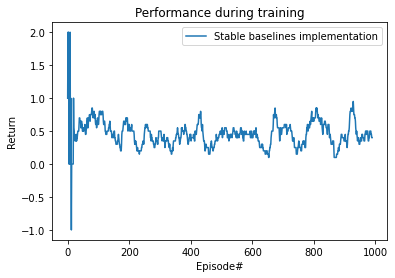

In [6]:

stable_baselines_episode_rewards = env.get_episode_rewards()
stable_baselines_moving_average_of_rewards = stable_baselines_episode_rewards.copy()
for i in range(20, len(stable_baselines_episode_rewards)):
  stable_baselines_moving_average_of_rewards[i] = np.mean(stable_baselines_episode_rewards[i - 20: i])

plt.xlabel("Episode#") 
plt.ylabel("Return") 
plt.title("Performance during training")
plt.plot(stable_baselines_moving_average_of_rewards, label='Stable baselines implementation')  
plt.legend()
plt.show()

In [7]:
!zip -r PPO_Recurrent_Frame_Skip_1_checkpoints.zip PPO_Recurrent_Frame_Skip_1_checkpoints 

  adding: PPO_Recurrent_Frame_Skip_1_checkpoints/ (stored 0%)
  adding: PPO_Recurrent_Frame_Skip_1_checkpoints/rl_model_225000_steps.zip (stored 0%)
  adding: PPO_Recurrent_Frame_Skip_1_checkpoints/rl_model_100000_steps.zip (stored 0%)
  adding: PPO_Recurrent_Frame_Skip_1_checkpoints/rl_model_75000_steps.zip (stored 0%)
  adding: PPO_Recurrent_Frame_Skip_1_checkpoints/rl_model_125000_steps.zip (stored 0%)
  adding: PPO_Recurrent_Frame_Skip_1_checkpoints/rl_model_175000_steps.zip (stored 0%)
  adding: PPO_Recurrent_Frame_Skip_1_checkpoints/rl_model_50000_steps.zip (stored 0%)
  adding: PPO_Recurrent_Frame_Skip_1_checkpoints/rl_model_300000_steps.zip (stored 0%)
  adding: PPO_Recurrent_Frame_Skip_1_checkpoints/rl_model_25000_steps.zip (stored 0%)
  adding: PPO_Recurrent_Frame_Skip_1_checkpoints/rl_model_275000_steps.zip (stored 0%)
  adding: PPO_Recurrent_Frame_Skip_1_checkpoints/rl_model_200000_steps.zip (stored 0%)
  adding: PPO_Recurrent_Frame_Skip_1_checkpoints/rl_model_250000_steps.

Evaluate checkpoints and find the best checkpoint for the PPO model (This will not work for Recurrent PPO, that is in the next cell.)

In [25]:
all_checkpoints = os.listdir(f"./{build_name}_checkpoints")

env = gym.make(DEFAULT_ENV, frame_skip=FRAME_SKIP)
env = ObservationWrapper(env)
env = Monitor(env)

best_performance = 0
best_performer = ""
checkpoint_performances = []
for checkpoint in all_checkpoints:
  if "rl_model" not in checkpoint:
    continue
  model = PPO.load(f"./{build_name}_checkpoints/{checkpoint}")
  episodic_rewards = []
  for i in range(10):
    done = False
    obs = env.reset()
    total_reward = 0
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward
    episodic_rewards.append(total_reward)

  checkpoint_performance = np.mean(episodic_rewards)
  checkpoint_performances.append(checkpoint_performance)
  if checkpoint_performance > best_performance:
    best_performance = checkpoint_performance
    best_performer = checkpoint

print(f"checkpoint {best_performer} did best with score {best_performance}")
print(checkpoint_performances)
      



checkpoint rl_model_210000_steps.zip did best with score 20.5
[12.1, 12.5, 10.3, 5.6, 15.8, 13.6, 13.5, 17.7, 7.6, 5.8, 12.9, 13.6, 10.9, 8.6, 16.0, 12.5, 12.1, 2.3, 9.1, 9.2, 7.9, 8.3, 5.3, 20.5, 8.6]


Evaluate checkpoints and find the best checkpoint for the Recurrent PPO model

In [11]:
import os

all_checkpoints = os.listdir(f"./{build_name}_checkpoints")

env = gym.make(DEFAULT_ENV, frame_skip=FRAME_SKIP)
env = ObservationWrapper(env)
env = Monitor(env)

best_performance = 0
best_performer = ""
checkpoint_performances = []
for checkpoint in all_checkpoints:
  if "rl_model" not in checkpoint:
    continue
  print(checkpoint)
  model = RecurrentPPO.load(f"./{build_name}_checkpoints/{checkpoint}")
  episodic_rewards = []
  for i in range(10):
    done = False
    obs = env.reset()
    lstm_states = None
    num_envs = 1
    episode_starts = np.ones((num_envs,), dtype=bool)
    total_reward = 0
    while not done:
        action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
        obs, reward, done, info = env.step(action)
        episode_starts = done
        total_reward += reward
    episodic_rewards.append(total_reward)

  checkpoint_performance = np.mean(episodic_rewards)
  print(checkpoint_performance)
  checkpoint_performances.append(checkpoint_performance)
  if checkpoint_performance > best_performance:
    best_performance = checkpoint_performance
    best_performer = checkpoint

print(f"checkpoint {best_performer} did best with score {best_performance}")
print(checkpoint_performances)
      



/usr/local/lib/python3.8/dist-packages/vizdoom/gym_wrapper/base_gym_env.py:51: UserWarning: Detected screen format CRCGCB. Only RGB24 is supported in the Gym wrapper. Forcing RGB24.
  warnings.warn(f"Detected screen format {screen_format.name}. Only RGB24 is supported in the Gym wrapper. Forcing RGB24.")


rl_model_225000_steps.zip
0.4
rl_model_100000_steps.zip
0.2
rl_model_75000_steps.zip
0.7
rl_model_125000_steps.zip
0.7
rl_model_175000_steps.zip
0.3
rl_model_50000_steps.zip
0.5
rl_model_300000_steps.zip
0.5
rl_model_25000_steps.zip
0.1
rl_model_275000_steps.zip
0.3
rl_model_200000_steps.zip
0.6
rl_model_250000_steps.zip
0.5
rl_model_150000_steps.zip
0.5
checkpoint rl_model_75000_steps.zip did best with score 0.7
[0.4, 0.2, 0.7, 0.7, 0.3, 0.5, 0.5, 0.1, 0.3, 0.6, 0.5, 0.5]


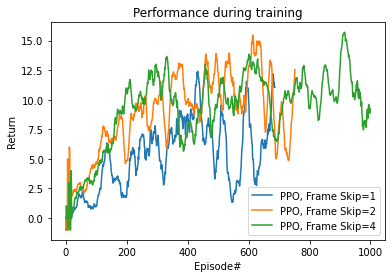

In [11]:
import matplotlib.pyplot as plt
import pickle
import numpy as np


def get_20_episode_average_rewards(episode_rewards):
  stable_baselines_episode_rewards = episode_rewards
  stable_baselines_moving_average_of_rewards = stable_baselines_episode_rewards.copy()
  for i in range(20, len(stable_baselines_episode_rewards)):
    stable_baselines_moving_average_of_rewards[i] = np.mean(stable_baselines_episode_rewards[i - 20: i])
  return stable_baselines_moving_average_of_rewards

with open('PPO_Frame_Skip_1_rewards.pickle', 'rb') as handle:
    PPO_Frame_Skip_1_rewards = pickle.load(handle)
    PPO_Frame_Skip_1_rewards_avg = get_20_episode_average_rewards(PPO_Frame_Skip_1_rewards)

with open('PPO_Frame_Skip_2_rewards.pickle', 'rb') as handle:
    PPO_Frame_Skip_2_rewards = pickle.load(handle)
    PPO_Frame_Skip_2_rewards_avg = get_20_episode_average_rewards(PPO_Frame_Skip_2_rewards)

with open('PPO_Frame_Skip_4_rewards.pickle', 'rb') as handle:
    PPO_Frame_Skip_4_rewards = pickle.load(handle)
    PPO_Frame_Skip_4_rewards_avg = get_20_episode_average_rewards(PPO_Frame_Skip_4_rewards)

with open('PPO_Recurrent_Frame_Skip_1_rewards.pickle', 'rb') as handle:
    PPO_Recurrent_Frame_Skip_1_rewards = pickle.load(handle)
    PPO_Recurrent_Frame_Skip_1_rewards_avg = get_20_episode_average_rewards(PPO_Recurrent_Frame_Skip_1_rewards)

with open('PPO_Recurrent_Frame_Skip_2_rewards.pickle', 'rb') as handle:
    PPO_Recurrent_Frame_Skip_2_rewards = pickle.load(handle)
    PPO_Recurrent_Frame_Skip_2_rewards_avg = get_20_episode_average_rewards(PPO_Recurrent_Frame_Skip_2_rewards)

with open('PPO_Recurrent_Frame_Skip_4_rewards.pickle', 'rb') as handle:
    PPO_Recurrent_Frame_Skip_4_rewards = pickle.load(handle)
    PPO_Recurrent_Frame_Skip_4_rewards_avg = get_20_episode_average_rewards(PPO_Recurrent_Frame_Skip_4_rewards)

plt.xlabel("Episode#") 
plt.ylabel("Return") 
plt.title("Performance during training")
plt.plot(PPO_Frame_Skip_1_rewards_avg, label='PPO, Frame Skip=1')  
plt.plot(PPO_Frame_Skip_2_rewards_avg, label='PPO, Frame Skip=2')  
plt.plot(PPO_Frame_Skip_4_rewards_avg[:1000], label='PPO, Frame Skip=4')  
# plt.plot(PPO_Recurrent_Frame_Skip_1_rewards_avg, label='Recurrent PPO, Frame Skip = 1')  
# plt.plot(PPO_Recurrent_Frame_Skip_2_rewards_avg, label='Recurrent PPO, Frame Skip = 2')  
# plt.plot(PPO_Recurrent_Frame_Skip_4_rewards_avg, label='Recurrent PPO, Frame Skip = 4')  
plt.legend()
plt.show()

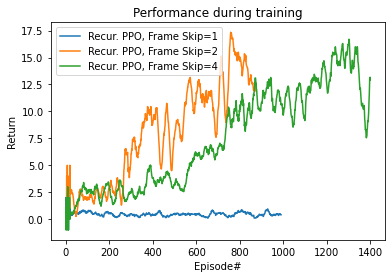

In [14]:
plt.xlabel("Episode#") 
plt.ylabel("Return") 
plt.title("Performance during training")
# plt.plot(PPO_Frame_Skip_1_rewards_avg, label='PPO, Frame Skip=1')  
# plt.plot(PPO_Frame_Skip_2_rewards_avg, label='PPO, Frame Skip=2')  
# plt.plot(PPO_Frame_Skip_4_rewards_avg[:1000], label='PPO, Frame Skip=4')  
plt.plot(PPO_Recurrent_Frame_Skip_1_rewards_avg, label='Recur. PPO, Frame Skip=1')  
plt.plot(PPO_Recurrent_Frame_Skip_2_rewards_avg, label='Recur. PPO, Frame Skip=2')  
plt.plot(PPO_Recurrent_Frame_Skip_4_rewards_avg[:1400], label='Recur. PPO, Frame Skip=4')  
plt.legend()
plt.show()